In [ ]:
#default_exp data.block

In [ ]:
#export
from fastai2.torch_basics import *
from fastai2.data.core import *
from fastai2.data.load import *
from fastai2.data.external import *
from fastai2.data.transforms import *


# TODO: fix add_props in fastcore utils so class Dataloaders can work
# def add_props(f, g=None, n=2):
#     "Create properties passing each of `range(n)` to f"
#     if g is None: return (property(partial(f,i)) for i in range(n))
#     return (property(partial(f,i), partial(g,i)) for i in range(n))

In [ ]:

from nbdev.showdoc import *

# Data block

> High level API to quickly get your data in a `DataBunch`

## Transform block

In [ ]:
#export
class TransformBlock():
    "A basic wrapper that links defaults transforms for the data block API"
    def __init__(self, type_tfms=None, item_tfms=None, batch_tfms=None, dl_type=None, dls_kwargs=None):
        self.type_tfms  =            L(type_tfms) # tfms for a specific type, e.g. for Category type, you need Categorize tfms
        self.item_tfms  = ToTensor + L(item_tfms) # after_item tfms
        self.batch_tfms =            L(batch_tfms) # after_batch tfms
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)

In [ ]:
#export
def CategoryBlock(vocab=None, add_na=False):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=Categorize(vocab=vocab, add_na=add_na))


def MultiCategoryBlock(encoded=False, vocab=None, add_na=False):
    "`TransformBlock` for multi-label categorical targets"
    tfm = EncodedMultiCategorize(vocab=vocab) if encoded else [MultiCategorize(vocab=vocab, add_na=add_na), OneHotEncode]
    return TransformBlock(type_tfms=tfm)

def RegressionBlock(c_out=None):
    "`TransformBlock` for float targets"
    return TransformBlock(type_tfms=RegressionSetup(c_out))

## General API

In [ ]:
#export
from inspect import isfunction,ismethod

In [ ]:
#export
def _merge_tfms(*tfms):
    "Group the `tfms` in a single list, removing duplicates (from the same class) and instantiating"
    g = groupby(concat(*tfms), lambda o:
        o if isinstance(o, type) else o.__qualname__ if (isfunction(o) or ismethod(o)) else o.__class__)
    return L(v[-1] for k,v in g.items()).map(instantiate)

def _zip(x): return L(x).zip()

In [ ]:
#For example, so not exported
from fastai2.vision.core import *
from fastai2.vision.data import *

In [ ]:
tfms = _merge_tfms([Categorize, MultiCategorize, Categorize(['dog', 'cat'])], Categorize(['a', 'b']))
#If there are several instantiated versions, the last one is kept.
test_eq(len(tfms), 2)
test_eq(tfms[1].__class__, MultiCategorize)
test_eq(tfms[0].__class__, Categorize)
test_eq(tfms[0].vocab, ['a', 'b'])

tfms = _merge_tfms([PILImage.create, PILImage.show])
#Check methods are properly separated
test_eq(len(tfms), 2)
tfms = _merge_tfms([show_image, set_trace])
#Check functions are properly separated
test_eq(len(tfms), 2)

In [ ]:
@docs
@funcs_kwargs  # look for stuff inside _methods, and determine whether some of **kwargs in __init__ will be in _methods, 
# then override the mentioned class method with it. 
class DataBlock():
    "Generic container to quickly build `Datasets` and `DataLoaders`"
    get_x=get_items=splitter=get_y = None
    blocks,dl_type = (TransformBlock,TransformBlock),TfmdDL
    _methods = 'get_items splitter get_y get_x'.split()
    def __init__(self, blocks=None, dl_type=None, getters=None, n_inp=None, item_tfms=None, batch_tfms=None, **kwargs):
        blocks = L(self.blocks if blocks is None else blocks)
        blocks = L(b() if callable(b) else b for b in blocks)
        
        # get default type tfms
        self.type_tfms = blocks.attrgot('type_tfms', L())
        
        # get the default tfms (tfms for items and batch) from the type/block
        self.default_item_tfms  = _merge_tfms(*blocks.attrgot('item_tfms',  L()))
        self.default_batch_tfms = _merge_tfms(*blocks.attrgot('batch_tfms', L()))
        
        for b in blocks: 
            if getattr(b, 'dl_type', None) is not None: self.dl_type = b.dl_type
        if dl_type is not None: self.dl_type = dl_type
        self.dataloaders = delegates(self.dl_type.__init__)(self.dataloaders)
        self.dls_kwargs = merge(*blocks.attrgot('dls_kwargs', {}))
        
        self.getters = [noop] * len(self.type_tfms) if getters is None else getters
        if self.get_x: self.getters[0] = self.get_x
        if self.get_y: self.getters[1] = self.get_y
        self.n_inp = n_inp
        
        if kwargs: raise TypeError(f'invalid keyword arguments: {", ".join(kwargs.keys())}')
        self.new(item_tfms, batch_tfms)
        
    def _combine_type_tfms(self): return L([self.getters, self.type_tfms]).map_zip(lambda g,tt: L(g) + tt)
        
    def new(self, item_tfms=None, batch_tfms=None): # merge default with extra tfms you put in __init__ such as image aug
        self.item_tfms  = _merge_tfms(self.default_item_tfms,  item_tfms)
        self.batch_tfms = _merge_tfms(self.default_batch_tfms, batch_tfms)
        return self
    
    @classmethod
    def from_columns(cls, blocks=None, getters=None, get_items=None, **kwargs):
        if getters is None: getters = L(ItemGetter(i) for i in range(2 if blocks is None else len(L(blocks))))
        get_items = _zip if get_items is None else compose(get_items, _zip)
        return cls(blocks=blocks, getters=getters, get_items=get_items, **kwargs)

    def datasets(self, source, verbose=False):
        self.source = source                     ; pv(f"Collecting items from {source}", verbose)
        items = (self.get_items or noop)(source) ; pv(f"Found {len(items)} items", verbose)
        splits = (self.splitter or RandomSplitter())(items)  
        pv(f"{len(splits)} datasets of sizes {','.join([str(len(s)) for s in splits])}", verbose)
        return Datasets(items, tfms=self._combine_type_tfms(), splits=splits, dl_type=self.dl_type, n_inp=self.n_inp, verbose=verbose)

    def dataloaders(self, source, path='.', verbose=False, **kwargs):
        dsets = self.datasets(source)
        kwargs = {**self.dls_kwargs, **kwargs, 'verbose': verbose}
        return dsets.dataloaders(path=path, after_item=self.item_tfms, after_batch=self.batch_tfms, **kwargs)

    _docs = dict(new="Create a new `DataBlock` with other `item_tfms` and `batch_tfms`",
                 datasets="Create a `Datasets` object from `source`",
                 dataloaders="Create a `DataLoaders` object from `source`")

In [ ]:
??ColReader

## The use of DataBlock: to automatically construct a Datasets or Dataloaders

To build a `DataBlock` you need to give the library four things: the types of your input/labels then at least two functions: `get_items` and `splitter`. You may also need to include `get_x` and `get_y` or a more generic list of `getters` that are applied to the results of `get_items`.

Once those are provided, you automatically get a `Datasets` or a `DataLoaders`:

In [ ]:
#hide_input
dblock = DataBlock()
show_doc(dblock.dataloaders, name="DataBlock.dataloaders")

<h4 id="DataBlock.dataloaders" class="doc_header"><code>DataBlock.dataloaders</code><a href="__main__.py#L48" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.dataloaders</code>(**`source`**, **`path`**=*`'.'`*, **`verbose`**=*`False`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`device`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create a [`DataLoaders`](/data.core#DataLoaders) object from `source`

You can create a `DataBlock` by passing functions or subclassing. The two following data blocks are the same for instance:

In [ ]:
class MNIST(DataBlock):
    blocks = ImageBlock(cls=PILImageBW),CategoryBlock # type of X (PILImageBW), and type of y (TensorCategory)
    # these 'blocks' contain TYPE transforms needed to CREATE and USE that specific type, 
    # this is why we have PILBase.create (with 'black and white' mode input) tfm at the end of X pipeline 
    # and Categorize tfm at the end of y pipeline
    # remember that X and y pipeline are for DATASETS
    
    # these 2 blocks adds some 'default' tfms for DATALOADERS (such as ToTensor and IntToFloatTensor, see below)
    
    def get_items(self, source): 
        # source is the path where items are located
        # output: get all items (for MNIST it's a list of paths)
        # note that this is not included as a tfm or in pipeline, since we need this list first in order to do ANYTHING
        # Note: if you return a tuple of (all Xs, all ys), then no need to define get_x, get_y 
        # (see planet example in dblock tutorial notebook. TODO: run the planet example)
        
        # bonus 1: get_items is useful if you have to do an extra step to get the list of items yourself
        # if you already have that list of items, don't need to define get_items in datablock __init__
        
        # bonus 2: what will items of this list go? these img paths will go through x pipeline: PILBase.create 
        # for y, y pipeline is: [parent_label (see get_y), Categorize]
        return get_image_files(Path(source))
    
    def splitter (self, items ): 
        # use a train/val splitter function on the list of items.
        # return list of 2: 1 for train, 1 for val
        return GrandparentSplitter()(items)
    
    def get_y    (self, item  ): 
        # input: 1 single item, from the list of items from get_items
        # output: the label (y) of that one item 
        # if multi-label, get the list of labels, e.g.: if item is [X,y], get_y = lambda inp: inp[1].split(' '))
        # this fn will be added to y pipeline
        return parent_label(item)
    
    def get_x    (self, item  ): pass
        # you can provide a get_x function: given 1 single item, return the X portion of that item
        # e.g. if item is a tuple (X,y), return item[0] aka X
mnist = MNIST()

In [ ]:
# equivalent to
mnist = DataBlock(blocks = (ImageBlock(cls=PILImageBW),CategoryBlock),
                  get_items = get_image_files,
                  splitter = GrandparentSplitter(),
                  get_y = parent_label)

Each type comes with default transforms that will be applied
- at the base level to create items in a tuple (usually input,target) from the base elements (like filenames)
- at the item level of the datasource
- at the batch level

They are called respectively type transforms, item transforms, batch transforms. In the case of MNIST, the type transforms are the method to create a `PILImageBW` (for the input) and the `Categorize` transform (for the target), the item transform is `ToTensor` and the batch transforms are `Cuda` and `IntToFloatTensor`. You can add any other transforms by passing them in `DataBlock.datasets` or `DataBlock.dataloaders`.

In [ ]:
??PILBase

In [ ]:
mnist.type_tfms[0] # type tfm for X pipeline

(#1) [<bound method PILBase.create of <class 'fastai2.vision.core.PILImageBW'>>]

In [ ]:
mnist.type_tfms[1][0] # type tfm for y pipeline

Categorize: (object,object) -> encodes (object,object) -> decodes

In [ ]:
type(mnist.type_tfms[1][0]) # Categorize (class inherit from Transform), will be included in y pipeline

fastai2.data.transforms.Categorize

In [ ]:
test_eq(mnist.type_tfms[0], [PILImageBW.create])
test_eq(mnist.type_tfms[1].map(type), [Categorize])

In [ ]:
test_eq(mnist.default_item_tfms.map(type), [ToTensor])
test_eq(mnist.default_batch_tfms.map(type), [IntToFloatTensor])

In [ ]:
print(mnist.default_item_tfms[0]) #default item tfm (for dataloaders' after_item pipeline) for PILBase: ToTensor (2 encodes)

print(mnist.default_batch_tfms[0]) # default batch item tfm (for dataloaders' after_batch pipeline): IntToFloatTensor (2 encodes)

ToTensor: (PILMask,object) -> encodes
(PILBase,object) -> encodes 
IntToFloatTensor: (TensorMask,object) -> encodes
(TensorImage,object) -> encodes (TensorImage,object) -> decodes


In [ ]:
#same as above, since we don't have extra item_tfms or batch_tfms in datablock __init__. If there are, they will be in here
#see def new to see why
print(mnist.item_tfms[0])
print(mnist.batch_tfms[0])

ToTensor: (PILMask,object) -> encodes
(PILBase,object) -> encodes 
IntToFloatTensor: (TensorMask,object) -> encodes
(TensorImage,object) -> encodes (TensorImage,object) -> decodes


### You can create datasets or dataloaders using datablock

In [ ]:
untar_data(URLs.MNIST_TINY)

Path('/home/quantran/.fastai/data/mnist_tiny')

In [ ]:
dsets = mnist.datasets(untar_data(URLs.MNIST_TINY))

In [ ]:
len(dsets.train), len(dsets.valid) # use GrandParent splitter to split train/val

(709, 699)

In [ ]:
dsets.tls[0].tfms,dsets.tls[1].tfms # X and y pipelines transformation

(Pipeline: PILBase.create, Pipeline: parent_label -> Categorize)

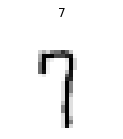

In [ ]:
test_eq(dsets.vocab, ['3', '7'])
x,y = dsets.train[0]
test_eq(x.size,(28,28))
show_at(dsets.train, 0, cmap='Greys', figsize=(2,2));

In [ ]:
type(x),y.type()

(fastai2.vision.core.PILImageBW, 'torch.LongTensor')

In [ ]:
type(y),y.type()

(fastai2.torch_core.TensorCategory, 'torch.LongTensor')

In [ ]:
dbunch = mnist.dataloaders(untar_data(URLs.MNIST_TINY)) # TODO: bug

Could not do one pass in your dataloader, there is something wrong in it
